# Setup

In [ ]:
#!pip install datasets sentence-transformers selfcheckgpt stanford_openie sentencepiece transformers
#!python -m spacy download en_core_web_sm

In [1]:
import pickle
import torch
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from tqdm import tqdm
from typing import List
from datasets import load_dataset
from selfcheckgpt.modeling_selfcheck import SelfCheckBERTScore
from sklearn.metrics import precision_recall_curve, auc
from sentence_transformers import SentenceTransformer

# Ngram 정의

In [2]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class NltkStopword:
    nltk.download("stopwords")
    stop_words = set(stopwords.words('english'))

class SelfCheckNgram:
    """
    SelfCheckGPT (Ngram variant): Checking LLM's text against its own sampled texts via ngram
    """
    def __init__(self, device=None):    
        if device is None:
            device = torch.device("cpu")
        self.device = device
        self.ngram_range = (1,1)

        print("SelfCheck-ngram initialized to device", device)

        """
        This function takes sentences (to be evaluated) with sampled passages (evidence), and return sent-level scores
        :param sentences: list[str] -- sentences to be evaluated, e.g., GPT text response split by spacy
        :param sampled_passages: list[list[str]] -- stochastically generated responses (split into sentences)
        :return sent_scores: list[float] -- sentence-level scores indicating hallucination probability
        """
    
    def preditc(self, sentences: List[str], sampled_passages: List[List[str]]):
        scores = []
        vectorizer = CountVectorizer(analyzer='word', ngram_range=self.ngram_range)
        
        for sp in sentences:
            similarities = []
            for sp_ps in sampled_passages:         
                X = vectorizer.fit_transform([sp, sp_ps])
                cos_sim = cosine_similarity(X[0], X[1])
                similarities.append(cos_sim)
                
            # 평균 유사도 계산
            avg_max_similarity = np.mean(similarities)
            scores.append(avg_max_similarity)

        return scores

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jjae0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# HHEM 정의

In [3]:
from sentence_transformers import CrossEncoder

class SelfCheckHHEM:
    """
    SelfCheckGPT (HHEM variant): Checking LLM's text against its own sampled texts via HHEM
    """
    def __init__(self, model_name='vectara/hallucination_evaluation_model', device=None):
        
        if device is None:
            device = torch.device("cpu")
        self.device = device
        self.model = CrossEncoder(model_name,device=device)

        print("SelfCheck-HHEM initialized to device", device)

    def preditc(self, sentences: List[str], sampled_passages: List[List[str]]):
        """
        This function takes sentences (to be evaluated) with sampled passages (evidence), and return sent-level scores
        :param sentences: list[str] -- sentences to be evaluated, e.g., GPT text response split by spacy
        :param sampled_passages: list[list[str]] -- stochastically generated responses (split into sentences)
        :return sent_scores: list[float] -- sentence-level scores indicating hallucination probability
        """

        scores = [] 
        for sp in sentences:
            similarities = []
            for sp_ps in sampled_passages:
                sp.replace('\n', '')
                similarities.append(self.model.predict([sp, sp_ps]))
                
            avg_max_similarity = np.mean(similarities)
            scores.append(avg_max_similarity)
   
        return scores

# Sentence-Bert 정의

In [4]:
class SelfCheckSBERT:
    """
    SelfCheckGPT (SBERT variant): Checking LLM's text against its own sampled texts via Sentence-BERT
    """
    def __init__(self, model_name='paraphrase-MiniLM-L6-v2', device=None):
        self.model = SentenceTransformer(model_name)
        if device is None:
            device = torch.device("cpu")
        self.device = device
        self.model.to(self.device)
        print("SelfCheck-SBERT initialized to device", device)

    def cosine_similarity(self, embedding1, embedding2):
        return torch.nn.functional.cosine_similarity(embedding1, embedding2, dim=-1)

    def predict(self, sentences: List[str], sampled_passages: List[List[str]]):
        """
        This function takes sentences (to be evaluated) with sampled passages (evidence), and return sent-level scores
        :param sentences: list[str] -- sentences to be evaluated, e.g., GPT text response split by spacy
        :param sampled_passages: list[list[str]] -- stochastically generated responses (split into sentences)
        :return sent_scores: list[float] -- sentence-level scores indicating hallucination probability
        """
        # 응답 문장 임베딩 계산
        response_embeddings = self.model.encode(sentences, convert_to_tensor=True)

        # 샘플 문장 임베딩 계산
        sample_embeddings = [self.model.encode(sample, convert_to_tensor=True) for sample in sampled_passages]

        scores = []

        for response_embedding in response_embeddings:
            max_similarities = []
            for sample_embedding in sample_embeddings:
                # 각 샘플에서 가장 유사한 문장 찾기
                similarities = self.cosine_similarity(response_embedding.unsqueeze(0), sample_embedding)
                max_similarity = torch.max(similarities).item()
                max_similarities.append(max_similarity)

            # 평균 유사도 계산
            avg_max_similarity = np.mean(max_similarities)
            score = 1 - avg_max_similarity
            scores.append(score)

        return scores

In [5]:
import spacy
import bert_score
import numpy as np
import torch
from tqdm import tqdm
from typing import Dict, List, Set, Tuple, Union
from transformers import logging
from openie import StanfordOpenIE
logging.set_verbosity_error()

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, AutoModel
from transformers import LongformerTokenizer, LongformerForMultipleChoice, LongformerForSequenceClassification
from transformers import DebertaV2ForSequenceClassification, DebertaV2Tokenizer
from openie import StanfordOpenIE

class NLIConfig:
    nli_model: str = "potsawee/deberta-v3-large-mnli"

class SelfCheckNLI:
    """
    SelfCheckGPT (NLI variant): Checking LLM's text against its own sampled texts via DeBERTa-v3 finetuned to Multi-NLI
    """
    def __init__(
        self,
        nli_model: str = None,
        device = None
    ):
        nli_model = nli_model if nli_model is not None else NLIConfig.nli_model
        self.tokenizer = DebertaV2Tokenizer.from_pretrained(nli_model)
        self.model = DebertaV2ForSequenceClassification.from_pretrained(nli_model)
        self.model.eval()
        if device is None:
            device = torch.device("cpu")
        self.model.to(device)
        self.device = device
        print("SelfCheck-NLI initialized to device", device)

    @torch.no_grad()
    def predict(
        self,
        sentences: List[str],
        sampled_passages: List[str],
    ):
        """
        This function takes sentences (to be evaluated) with sampled passages (evidence), and return sent-level scores
        :param sentences: list[str] -- sentences to be evaluated, e.g. GPT text response spilt by spacy
        :param sampled_passages: list[str] -- stochastically generated responses (without sentence splitting)
        :return sent_scores: sentence-level score which is P(condict|sentence, sample)
        note that we normalize the probability on "entailment" or "contradiction" classes only
        and the score is the probability of the "contradiction" class
        """
        num_sentences = len(sentences)
        num_samples = len(sampled_passages)
        scores = np.zeros((num_sentences, num_samples))
        for sent_i, sentence in enumerate(sentences):
            for sample_i, sample in enumerate(sampled_passages):
                inputs = self.tokenizer.batch_encode_plus(
                    batch_text_or_text_pairs=[(sentence, sample)],
                    add_special_tokens=True, padding="longest",
                    truncation=True, return_tensors="pt",
                    return_token_type_ids=True, return_attention_mask=True,
                )
                inputs = inputs.to(self.device)
                logits = self.model(**inputs).logits # neutral is already removed
                probs = torch.softmax(logits, dim=-1)
                prob_ = probs[0][1].item() # prob(contradiction)
                scores[sent_i, sample_i] = prob_
        scores_per_sentence = scores.mean(axis=-1)
        return scores_per_sentence
    

class SelfCheckOpenIE:
    # def __init__(self, model_name: str = 'fasttext-wiki-news-subwords-300', device=None):
    #     self.nlp = spacy.load("en_core_web_sm")
    #     self.model = api.load(model_name)  # Load FastText model
    #     self.device = device if device else torch.device("cpu")

    def __init__(
        self,
        model: str = "bert-base-uncased",
        device = None
    ):
        self.nlp = spacy.load("en_core_web_sm")
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.model = AutoModel.from_pretrained(model, torch_dtype="auto")
        self.model.eval()
        self.device = device if device else torch.device("cpu")
        self.model.to(device)
        self.properties = {
            'openie.affinity_probability_cap': 2 / 3,
        }
    
    def preprocess_text(self,text):
        doc = self.nlp(text)
        tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct]
        sent = " ".join(tokens)
        return sent

    def extract_triples(self, text) -> List[tuple]:
        triples=[]
        with StanfordOpenIE(properties=self.properties) as client:
            for triple in client.annotate(text):
                #{'subject': 'city', 'relation': 'is in', 'object': 'Ćolia'}
                triple_tuple= (triple['subject'],triple['relation'],triple['object'])
                triples.append(triple_tuple)
        return triples
            
    def compute_similarity(self, triple1: tuple, triple2: tuple) -> float:
        vec1 = self.convert_to_embedding(triple1)
        vec2 = self.convert_to_embedding(triple2)
        similarity = torch.cosine_similarity(vec1, vec2, dim=0)
        return similarity.mean().item() 

    def convert_to_embedding(self, triple: tuple) -> torch.Tensor:
        inputs = self.tokenizer(' '.join(triple), return_tensors='pt').to(self.device)
        outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1)

    @torch.no_grad()
    def predict(
        self,
        sentences: List[str],
        sampled_passages: List[str],
        verbose: bool = True,
    ):
        # sentences=[self.preprocess_text(sent) for sent in sentences]
        # sampled_passages=[self.preprocess_text(sent) for sent in sampled_passages]

        sentences_len= len(sentences)
        samples_len=len(sampled_passages)

        similarities = [0] * sentences_len
        sentence_triples = [self.extract_triples(sent) for sent in sentences]

        for j in range(samples_len):
            passage_triples = self.extract_triples(sampled_passages[j])            
            for i in range(sentences_len):
                max_similarity = 0
                for s_triple in sentence_triples[i]:
                    for p_triple in passage_triples:
                        similarity = self.compute_similarity(s_triple, p_triple)
                        #print(f's_triple: {s_triple}, p_triple: {p_triple} | similarity: {similarity}')
                        if similarity > max_similarity:
                            max_similarity = similarity
                similarities[i] += max_similarity
                if verbose:
                    print(f'similarities[{i}] updated by sample[{j}]: {similarities[i]}')
            if verbose:
                print('----------------------------------------------------------------------------------------')
        #Normalize
        normalized_similarities= [1- similarity / samples_len for similarity in similarities]
        if verbose:
            print(f'Similarities: {normalized_similarities}')
        return normalized_similarities

# 실험 데이터 호출

In [6]:
# indices in WikiBio of the evaluated examples
ids = load_dataset("potsawee/wiki_bio_gpt3_hallucination")['evaluation']['wiki_bio_test_idx']
dataset = load_dataset("potsawee/wiki_bio_gpt3_hallucination")
dataset = dataset['evaluation']

# 데이터 개수 체크 -- 수정하며 확인

In [7]:
dataset_len= 3 # len(dataset)

In [8]:
label_mapping = {
    'accurate': 0.0,
    'minor_inaccurate': 0.5,
    'major_inaccurate': 1.0,
}

passage_human_label_detect_scores = {}
human_label_detect_False   = {}
human_label_detect_False_h = {}
human_label_detect_True    = {}

for i_ in range(dataset_len):
    dataset_i = dataset[i_]
    idx = dataset_i['wiki_bio_test_idx']
    raw_label = np.array([label_mapping[x] for x in dataset_i['annotation']])
    human_label_detect_False[idx] = (raw_label > 0.499).astype(np.int32).tolist()
    human_label_detect_True[idx]  = (raw_label < 0.499).astype(np.int32).tolist()
    average_score = np.mean(raw_label)
    passage_human_label_detect_scores[idx]= average_score
    if average_score < 0.99:
        human_label_detect_False_h[idx] = (raw_label > 0.99).astype(np.int32).tolist()

In [9]:
def unroll_pred(scores, indices):
    unrolled = []
    for idx in indices:
        unrolled.extend(scores[idx])
    return unrolled

def get_PR_with_human_labels(preds, human_labels, pos_label=1, oneminus_pred=False):
    indices = [k for k in human_labels.keys()]
    unroll_preds = unroll_pred(preds, indices)
    if oneminus_pred:
        unroll_preds = [1.0-x for x in unroll_preds]
    unroll_labels = unroll_pred(human_labels, indices)
    assert len(unroll_preds) == len(unroll_labels)
    print("len:", len(unroll_preds))
    P, R, thre = precision_recall_curve(unroll_labels, unroll_preds, pos_label=pos_label)
    return P, R

def print_AUC(P, R):
    print("AUC: {:.2f}".format(auc(R, P)*100))

# 모델 호출 (정의)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device to 'cuda' if GPU is available

selfcheck_bertscore = SelfCheckBERTScore(rescale_with_baseline=True)
selfcheck_sbert = SelfCheckSBERT()
selfcheck_nli = SelfCheckNLI(device=device) 
selfcheck_openie= SelfCheckOpenIE(device=device)
selfcheck_hhem = SelfCheckHHEM(device=device)
selfcheck_ngram = SelfCheckNgram(device=device)

SelfCheck-BERTScore initialized


D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


SelfCheck-SBERT initialized to device cpu
SelfCheck-NLI initialized to device cpu
SelfCheck-HHEM initialized to device cpu
SelfCheck-ngram initialized to device cpu


# 계산 과정 (New)

In [11]:
import pickle
from tqdm import tqdm

bertscore_scores = {}
sbert_scores = {}
nli_scores = {}
openie_scores = {}
ngram_scores = {}
hhem_scores = {}

def save_scores_to_file(filename, scores):
    with open(filename, 'wb') as f:
        pickle.dump(scores, f)

for i_ in tqdm(range(dataset_len)):
    dataset_i = dataset[i_]
    idx = dataset_i['wiki_bio_test_idx']
    sentences = dataset_i['gpt3_sentences']
    sampled_passages = dataset_i['gpt3_text_samples'][:5]  # 테스트로 샘플 5개만 사용
    num_sentences = len(sentences)

    sent_scores_bertscore = selfcheck_bertscore.predict(
        sentences=sentences,
        sampled_passages=sampled_passages,
    )
    sent_scores_sbert = selfcheck_sbert.predict(
        sentences=sentences,
        sampled_passages=sampled_passages,
    )
    sent_scores_nli = selfcheck_nli.predict(
        sentences=sentences,
        sampled_passages=sampled_passages,
    )
    sent_scores_openie = selfcheck_openie.predict(
        sentences=sentences,
        sampled_passages=sampled_passages,
    )
    sent_scores_ngramscore = selfcheck_ngram.predict(
        sentences=sentences,
        sampled_passages=sampled_passages,
    )
    sent_scores_hhemscore = selfcheck_hhem.predict(
        sentences=sentences,
        sampled_passages=sampled_passages,
    )

    bertscore_scores[idx] = sent_scores_bertscore
    sbert_scores[idx] = sent_scores_sbert
    nli_scores[idx] = sent_scores_nli
    openie_scores[idx] = sent_scores_openie
    ngram_scores[idx] = sent_scores_ngramscore
    hhem_scores[idx] = sent_scores_hhemscore

    # 중간 결과 저장
    save_scores_to_file('bertscore_scores.pkl', bertscore_scores)
    save_scores_to_file('sbert_scores.pkl', sbert_scores)
    save_scores_to_file('nli_scores.pkl', nli_scores)
    save_scores_to_file('openie_scores.pkl', openie_scores)
    save_scores_to_file('ngram_scores.pkl', ngram_scores)
    save_scores_to_file('hhem_scores.pkl', hhem_scores)

  0%|          | 0/3 [00:00<?, ?it/s]D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed i

KeyboardInterrupt: 

In [12]:
bertscore_scores = {}
sbert_scores = {}
nli_scores = {} 
openie_scores = {} 
ngram_scores = {}
hhem_scores = {}
for i_ in tqdm(range(dataset_len)):
    dataset_i = dataset[i_]
    idx = dataset_i['wiki_bio_test_idx']
    sentences = dataset_i['gpt3_sentences']
    sampled_passages = dataset_i['gpt3_text_samples'][:3] # 테스트로 샘플 5개만 사용
    num_sentences = len(sentences)

    sent_scores_bertscore = selfcheck_bertscore.predict(
        sentences = sentences,
        sampled_passages = sampled_passages,
    )
    sent_scores_sbert = selfcheck_sbert.predict(
        sentences = sentences,
        sampled_passages = sampled_passages,
    )
    sent_scores_nli = selfcheck_nli.predict(
        sentences = sentences,
        sampled_passages = sampled_passages,
    )
    sent_scores_openie = selfcheck_openie.predict(
        sentences = sentences,
        sampled_passages = sampled_passages,
    )
    sent_scores_ngramscore = selfcheck_ngram.preditc(
    sentences = sentences,
    sampled_passages = sampled_passages,
    )
    sent_scores_hhemscore = selfcheck_hhem.preditc(
        sentences = sentences,
        sampled_passages = sampled_passages,
    )

    bertscore_scores[idx] = sent_scores_bertscore
    sbert_scores[idx] = sent_scores_sbert
    nli_scores[idx] = sent_scores_nli 
    openie_scores[idx] = sent_scores_openie
    ngram_scores[idx] = sent_scores_ngramscore
    hhem_scores[idx] = sent_scores_hhemscore    

  0%|          | 0/3 [00:00<?, ?it/s]D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-23f24bc385d54bee.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-4280cf209ab74be6.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f5b273f28bd948d3.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp

 33%|███▎      | 1/3 [14:40<29:21, 880.71s/it]D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-9481f090e9fb4f28.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-76e52a9450ee4fe2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-902c1eb98c9d4215.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp

 67%|██████▋   | 2/3 [24:13<11:39, 699.45s/it]D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-ab9668b84ee74dc2.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-bdf6bdddb6744215.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp-4.5.3/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-011e83b212ba42af.props -preload openie
Starting server with command: java -Xmx8G -cp C:\Users\jjae0\.stanfordnlp_resources\stanford-corenlp

100%|██████████| 3/3 [49:10<00:00, 983.64s/it] 


# 결과 추출

## 1. Experiment1: Detecting False

In [13]:
# with human label, Detecting False
Pb1, Rb1 = get_PR_with_human_labels(bertscore_scores, human_label_detect_False, pos_label=1)
Pb2, Rb2 = get_PR_with_human_labels(sbert_scores, human_label_detect_False, pos_label=1)
Pb3, Rb3 = get_PR_with_human_labels(nli_scores, human_label_detect_False, pos_label=1)
Pb4, Rb4 = get_PR_with_human_labels(openie_scores, human_label_detect_False, pos_label=1)
Pb5, Rb5 = get_PR_with_human_labels(ngram_scores, human_label_detect_False, pos_label=1)
Pb6, Rb6 = get_PR_with_human_labels(hhem_scores, human_label_detect_False, pos_label=1)

print("bertscore_scores")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("sbert_scores")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("nli_scores")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("openie_scores")
print_AUC(Pb4, Rb4)
print("-----------------------")
print("ngram_scores")
print_AUC(Pb5, Rb5)
print("-----------------------")
print("hhem_scores")
print_AUC(Pb6, Rb6)
print("-----------------------")

len: 25
len: 25
len: 25
len: 25
len: 25
len: 25
bertscore_scores
AUC: 99.83
-----------------------
sbert_scores
AUC: 99.47
-----------------------
nli_scores
AUC: 97.27
-----------------------
openie_scores
AUC: 99.27
-----------------------
ngram_scores
AUC: 96.58
-----------------------
hhem_scores
AUC: 97.27
-----------------------


In [14]:
# 랜던 추출
arr = []
for v in human_label_detect_False.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.96

Text(0.5, 0, 'Recall')

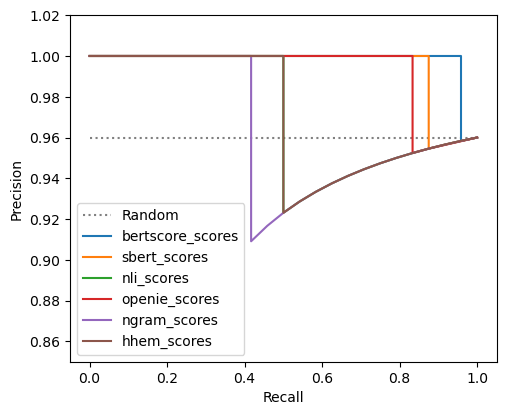

In [15]:
# with human label, Detecting Non-factual
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='bertscore_scores')
plt.plot(Rb2, Pb2, '-', label='sbert_scores')
plt.plot(Rb3, Pb3, '-', label='nli_scores')
plt.plot(Rb4, Pb4, '-', label='openie_scores')
plt.plot(Rb5, Pb5, '-', label='ngram_scores')
plt.plot(Rb6, Pb6, '-', label='hhem_scores')
plt.legend()
plt.ylim(0.85,1.02)
plt.ylabel("Precision")
plt.xlabel("Recall")

## 2. Experiment2: Detect False* (harder/less-trivial)

In [16]:
# with human label, Detecting False
Pb1, Rb1 = get_PR_with_human_labels(bertscore_scores, human_label_detect_False_h, pos_label=1)
Pb2, Rb2 = get_PR_with_human_labels(sbert_scores, human_label_detect_False_h, pos_label=1)
Pb3, Rb3 = get_PR_with_human_labels(nli_scores, human_label_detect_False_h, pos_label=1)
Pb4, Rb4 = get_PR_with_human_labels(openie_scores, human_label_detect_False_h, pos_label=1)
Pb5, Rb5 = get_PR_with_human_labels(ngram_scores, human_label_detect_False_h, pos_label=1)
Pb6, Rb6 = get_PR_with_human_labels(hhem_scores, human_label_detect_False_h, pos_label=1)
print("bertscore_scores")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("sbert_scores")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("nli_scores")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("openie_scores")
print_AUC(Pb4, Rb4)
print("-----------------------")
print("ngram_scores")
print_AUC(Pb5, Rb5)
print("-----------------------")
print("hhem_scores")
print_AUC(Pb6, Rb6)
print("-----------------------")

len: 16
len: 16
len: 16
len: 16
len: 16
len: 16
bertscore_scores
AUC: 43.84
-----------------------
sbert_scores
AUC: 80.22
-----------------------
nli_scores
AUC: 40.33
-----------------------
openie_scores
AUC: 56.37
-----------------------
ngram_scores
AUC: 34.92
-----------------------
hhem_scores
AUC: 31.27
-----------------------


In [17]:
arr = []
for v in human_label_detect_False_h.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.3125

Text(0.5, 0, 'Recall')

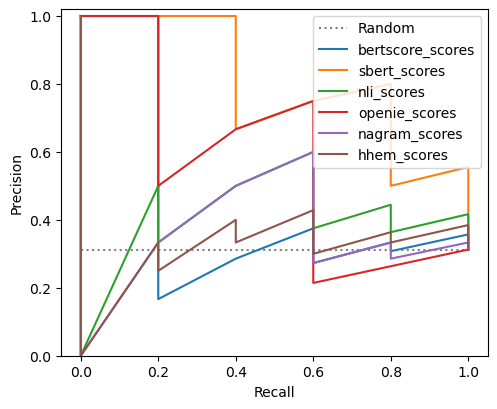

In [18]:
# with human label, Detecting Non-factual
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='bertscore_scores')
plt.plot(Rb2, Pb2, '-', label='sbert_scores')
plt.plot(Rb3, Pb3, '-', label='nli_scores')
plt.plot(Rb4, Pb4, '-', label='openie_scores')
plt.plot(Rb5, Pb5, '-', label='nagram_scores')
plt.plot(Rb6, Pb6, '-', label='hhem_scores')
plt.legend()
plt.ylim(0.0,1.02)
plt.ylabel("Precision")
plt.xlabel("Recall")

# Experiment3: Detecting True

In [19]:
# with human label, Detecting False
Pb1, Rb1 = get_PR_with_human_labels(bertscore_scores, human_label_detect_True, pos_label=1)
Pb2, Rb2 = get_PR_with_human_labels(sbert_scores, human_label_detect_True, pos_label=1)
Pb3, Rb3 = get_PR_with_human_labels(nli_scores, human_label_detect_True, pos_label=1)
Pb4, Rb4 = get_PR_with_human_labels(openie_scores, human_label_detect_True, pos_label=1)
Pb5, Rb5 = get_PR_with_human_labels(ngram_scores, human_label_detect_True, pos_label=1)
Pb6, Rb6 = get_PR_with_human_labels(hhem_scores, human_label_detect_True, pos_label=1)

print("bertscore_scores")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("sbert_scores")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("nli_scores")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("openie_scores")
print_AUC(Pb4, Rb4)
print("-----------------------")
print("ngram_scores")
print_AUC(Pb5, Rb5)
print("-----------------------")
print("hhem_scores")
print_AUC(Pb6, Rb6)
print("-----------------------")

len: 25
len: 25
len: 25
len: 25
len: 25
len: 25
bertscore_scores
AUC: 2.08
-----------------------
sbert_scores
AUC: 2.27
-----------------------
nli_scores
AUC: 3.85
-----------------------
openie_scores
AUC: 2.38
-----------------------
ngram_scores
AUC: 4.55
-----------------------
hhem_scores
AUC: 3.85
-----------------------


In [20]:
arr = []
for v in human_label_detect_True.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.04

Text(0.5, 0, 'Recall')

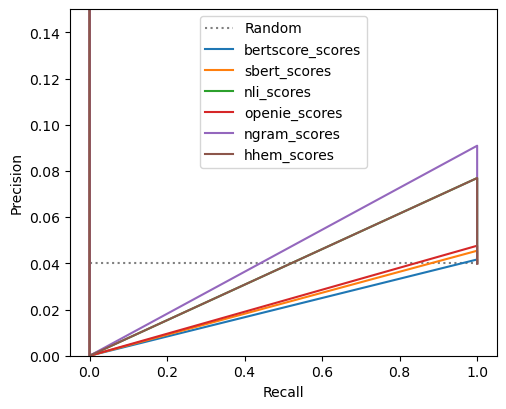

In [21]:
# with human label, Detecting Non-factual
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='bertscore_scores')
plt.plot(Rb2, Pb2, '-', label='sbert_scores')
plt.plot(Rb3, Pb3, '-', label='nli_scores')
plt.plot(Rb4, Pb4, '-', label='openie_scores')
plt.plot(Rb5, Pb5, '-', label='ngram_scores')
plt.plot(Rb6, Pb6, '-', label='hhem_scores')
plt.legend()
plt.ylim(0.0,0.15)
plt.ylabel("Precision")
plt.xlabel("Recall")

# PCC 계산

In [22]:
def get_selfcheck_passage_score_list(data):
    averages = {key: np.mean(values) for key, values in data.items()}
    sorted_averages = [averages[key] for key in sorted(averages)]
    return sorted_averages
#
def get_human_passage_score_list(input_dict):
    # 키를 정렬하고, 정렬된 키에 해당하는 값을 리스트로 추출
    sorted_values = [input_dict[key] for key in sorted(input_dict)]
    return sorted_values

def plot_scatter_and_regression(selfcheck_method_name, selfcheck_passage_scores):
    plt.scatter(human_passage_scores, selfcheck_passage_scores, alpha=0.5, color='gray')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(human_passage_scores, selfcheck_passage_scores)
    line_x = np.array([min(human_passage_scores), max(human_passage_scores)])
    line_y = slope * line_x + intercept
    plt.plot(line_x, line_y, 'r-', label=f'y={slope:.2f}x+{intercept:.2f}')

    plt.title(f'Scatter Plot with Regression Line for {selfcheck_method_name}')
    plt.xlabel('Human Score (0=Factual, +1=Non-Factual)')
    plt.ylabel('Method Score')
    plt.legend()
    
    plt.show()

In [23]:
human_passage_scores = get_human_passage_score_list(passage_human_label_detect_scores)
bertscore_passage_scores = get_selfcheck_passage_score_list(bertscore_scores)
sbert_passage_scores=get_selfcheck_passage_score_list(sbert_scores)
nli_passage_scores = get_selfcheck_passage_score_list(nli_scores)
openie_passage_scores=get_selfcheck_passage_score_list(openie_scores)
ngram_passage_scores=get_selfcheck_passage_score_list(ngram_scores)
hhem_passage_scores=get_selfcheck_passage_score_list(hhem_scores)


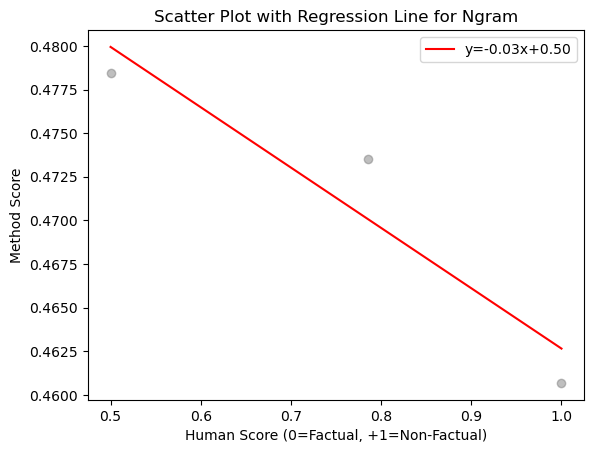

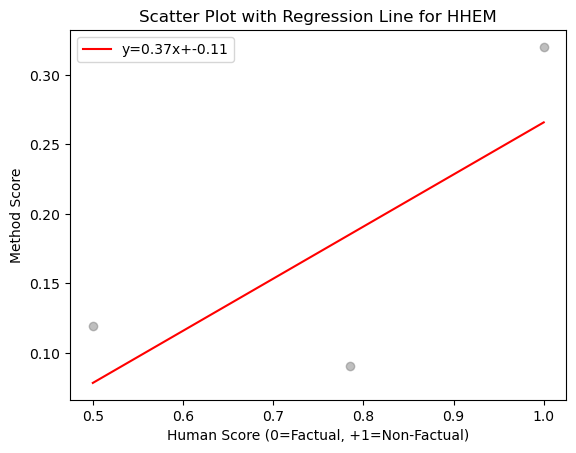

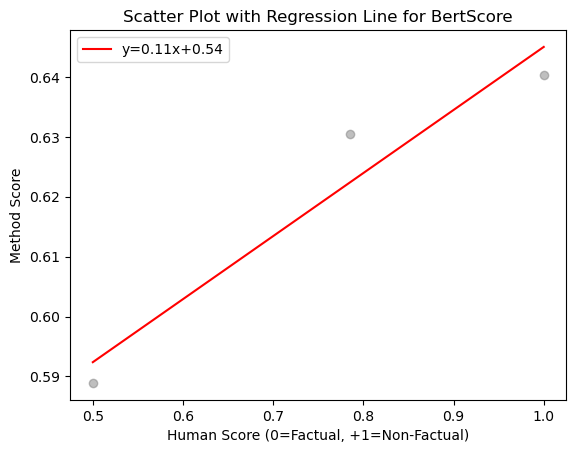

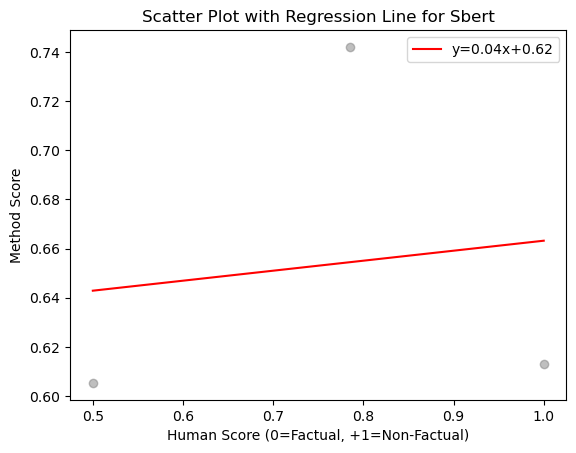

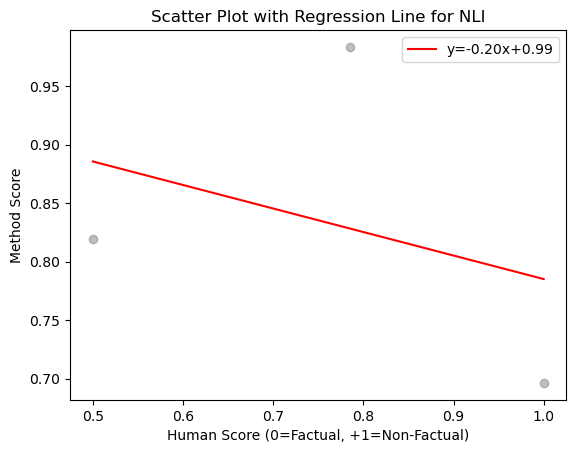

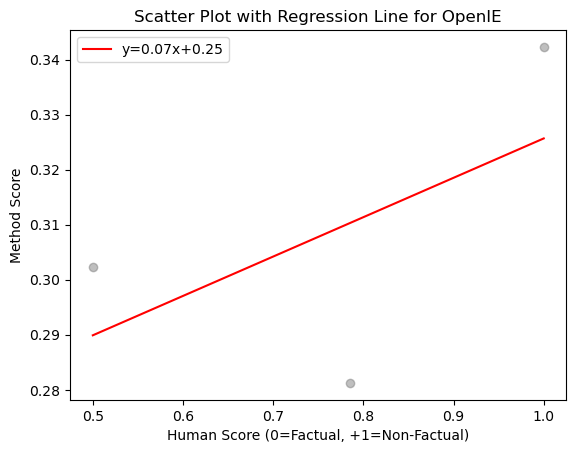

In [24]:
# 함수 호출 예시
plot_scatter_and_regression('Ngram', ngram_passage_scores)
plot_scatter_and_regression('HHEM', hhem_passage_scores)
plot_scatter_and_regression('BertScore', bertscore_passage_scores)
plot_scatter_and_regression('Sbert', sbert_passage_scores)
plot_scatter_and_regression('NLI', nli_passage_scores)
plot_scatter_and_regression('OpenIE', openie_passage_scores)